## DataLoader class and data loading

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from jetnet.datasets import JetNet
import numpy as np
from sklearn.preprocessing import OneHotEncoder

class DataLoaderOriginal:
  def __init__(self):
    pass

  def get_original_data(num_images=70000, LAST=False):
    ''' DOWNLOAD DATA '''
    #set args to load the data
    data_args = {
        "jet_type": ["g", "q", "t", "w", "z"],
        # ‘g’ (gluon), ‘q’ (light quarks), ‘t’ (top quarks), ‘w’ (W bosons), or ‘z’ (Z bosons)
        "data_dir": "datasets/jetnet",
        # only selecting the kinematic features
        "particle_features": ["etarel", "phirel", "ptrel"],
        "num_particles": 30,
        "jet_features": ["type"],
        "download": True,
        "split": "all",
    }

    # download as numpy arrays
    particle_data, jet_data = JetNet.getData(**data_args)

    if LAST == True:
      X_train = particle_data[-num_images:]
      Y_train = jet_data[-num_images:]
    else:
      X_train = particle_data[:num_images]
      Y_train = jet_data[:num_images]

    return X_train, Y_train

  def get_original_data_onehot(train=42000, valid=14000, test=14000):
    X_Data, Y_Data = DataLoaderOriginal.get_original_data(train+valid)
    # data split
    X_train, X_val = X_Data[:train], X_Data[train:]
    Y_train, Y_val = Y_Data[:train], Y_Data[train:]

    X_test, Y_test = DataLoaderOriginal.get_original_data(test, LAST=True)

    # one hot encoding the lables
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_train_onehot = one_hot_encoder.fit_transform(Y_train.reshape((-1,1)))
    Y_valid_onehot = one_hot_encoder.fit_transform(Y_val.reshape((-1,1)))
    Y_test_onehot = one_hot_encoder.fit_transform(Y_test.reshape((-1,1)))

    return X_train, X_val, X_test, Y_train_onehot, Y_valid_onehot, Y_test_onehot


In [6]:
# test
X_train, X_val, X_test, Y_train_onehot, Y_valid_onehot, Y_test_onehot = DataLoaderOriginal.get_original_data_onehot(train=200000, valid=50000, test=50000)

## ModelEval class

In [ ]:
# Update matplotlib parameters for better visualization
plt.rcParams.update({
  "font.family": "FreeSerif",
  "axes.labelsize": 15,
  "font.size": 15,
  "legend.fontsize": 10,
  "xtick.labelsize": 15,
  "ytick.labelsize": 15
})

class ModelEval:
  def __init__(self, model, X_test_set, Y_test_set, model_str="model", cmap='inferno'):
    self.X_test = X_test_set
    self.Y_test = Y_test_set
    self.cmap = cmap
    self.model_str = model_str
    self.model = model
    self.array_labels = ["gluon", "light\nquarks", "top\nquark", "W boson", "Z boson"]

    # Predict the test set
    self.Y_test_pred = self.model.predict(self.X_test)
    self.Y_test_pred_classes = np.argmax(self.Y_test_pred, axis=1)
    self.Y_test_classes = np.argmax(self.Y_test, axis=1)

  def Conf_Matrix_and_ROC_curve(self):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=200)
    plt.subplots_adjust(wspace=0.3)

    ''' Confusion Matrix '''
    from sklearn.metrics import confusion_matrix

    # Compute confusion matrix
    conf_m = confusion_matrix(self.Y_test_classes, self.Y_test_pred_classes)
    print("Confusion matrix of " + self.model_str)

    # Plot confusion matrix
    mappable = ax[0].matshow(conf_m, cmap=self.cmap)
    ax[0].set_title("Confusion matrix of " + self.model_str, pad=20)
    ax[0].set_xlabel("Predicted class", labelpad=10)
    ax[0].set_ylabel("True class")
    ax[0].set_xticks(range(5), self.array_labels)
    ax[0].set_yticks(range(5), self.array_labels)
    ax[0].set_aspect('equal')
    fig.colorbar(mappable=mappable, ax=ax[0], shrink=0.85)
    ax[0].xaxis.set_ticks_position("bottom")

    # Add text annotations for each element
    for i in range(conf_m.shape[0]):
      for j in range(conf_m.shape[1]):
        text = ax[0].text(j, i, conf_m[i, j], ha="center", va="center", color="green")

    ''' ROC Curve '''
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score

    # Plot ROC curve for each class
    for i in range(5):
      fpr, tpr, thresholds = roc_curve(self.Y_test[:,i], self.Y_test_pred[:, i])
      ax[1].plot(fpr, tpr, linewidth=2, label='{0} (area = {1:0.2f})'.format(self.array_labels[i], round(roc_auc_score(self.Y_test[:,i], self.Y_test_pred[:, i]), 5)))

    ax[1].plot([0, 1], [0, 1], 'k--') # dashed diagonal
    ax[1].grid(1)
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title("ROC curve")
    ax[1].legend(fontsize=15)
    ax[1].set_aspect('equal')
    plt.show()

  def accuracy_loss(self, hist):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=200)
    plt.subplots_adjust(wspace=0.2)

    # Plot training and validation accuracy
    ax[0].plot(hist['accuracy'], "--", label='Train Accuracy', color="deepskyblue")
    ax[0].plot(hist['val_accuracy'], ".-", label='Validation Accuracy', color="orange")
    ax[0].set_title("Accuracy " + self.model_str, pad=20)
    ax[0].set_xlabel("Epoch", labelpad=10)
    ax[0].legend(fontsize=15)

    # Plot training and validation loss
    ax[1].plot(hist['loss'], "--", label='Train Loss Function', color="deepskyblue")
    ax[1].plot(hist['val_loss'], ".-", label='Validation Loss Function', color="orange")
    ax[1].set_title("Loss function " + self.model_str, pad=20)
    ax[1].set_xlabel("Epoch", labelpad=10)
    ax[1].legend(fontsize=15)
    plt.show()

## Fully Connected NN - definition

In [ ]:
import pandas as pd
import tensorflow as tf

model0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = [30,3]),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(2500, activation='relu'),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(2000, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1800, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1500, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1500, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(800, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(5, activation='softmax'),
])

2025-01-23 18:07:50.117815: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 18:07:50.178381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-23 18:07:50.200292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-23 18:07:50.207822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 18:07:50.266186: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
model0.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_11 (Flatten)            │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 2500)           │       227,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 2500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 2500)           │        10,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 2000)           │     5,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 2000)           │         8,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1800)           │     3,601,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 1800)           │         7,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1500)           │     2,701,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 1500)           │         6,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1500)           │     2,251,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 1500)           │         6,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 800)            │     1,200,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 800)            │         3,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 200)            │       160,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 200)            │           80

 Total params: 15,218,005 (58.05 MB)

 Trainable params: 15,197,105 (57.97 MB)

 Non-trainable params: 20,900 (81.64 KB)

In [ ]:
model0.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy'],
)


history = model0.fit(
    X_train, Y_train_onehot,
    batch_size = 256,
    epochs = 20,
    validation_data = (X_val, Y_valid_onehot),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/20


I0000 00:00:1737652081.951137   87261 service.cc:146] XLA service 0x7e40700096f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737652081.951175   87261 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-01-23 18:08:02.006100: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-23 18:08:02.279921: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90100


 31/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3003 - loss: 1.8851

I0000 00:00:1737652086.078562   87261 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4870 - loss: 1.2901

2025-01-23 18:08:15.093714: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion', 24 bytes spill stores, 4 bytes spill loads



782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.4871 - loss: 1.2899 - val_accuracy: 0.6297 - val_loss: 0.9891
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6398 - loss: 0.9570 - val_accuracy: 0.6705 - val_loss: 0.8962
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6561 - loss: 0.9253 - val_accuracy: 0.6714 - val_loss: 0.9181
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6677 - loss: 0.9006 - val_accuracy: 0.6788 - val_loss: 0.8730
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6754 - loss: 0.8798 - val_accuracy: 0.6908 - val_loss: 0.8464
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6840 - loss: 0.8632 - val_accuracy: 0.6921 - val_loss: 0.8541
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6919 - loss: 0.8481 - val_accuracy: 0.6978 - val_loss: 0.8398
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6961 - loss: 0.8389 - val_accuracy: 0.6946 - va

## Fully Connected NN - results

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


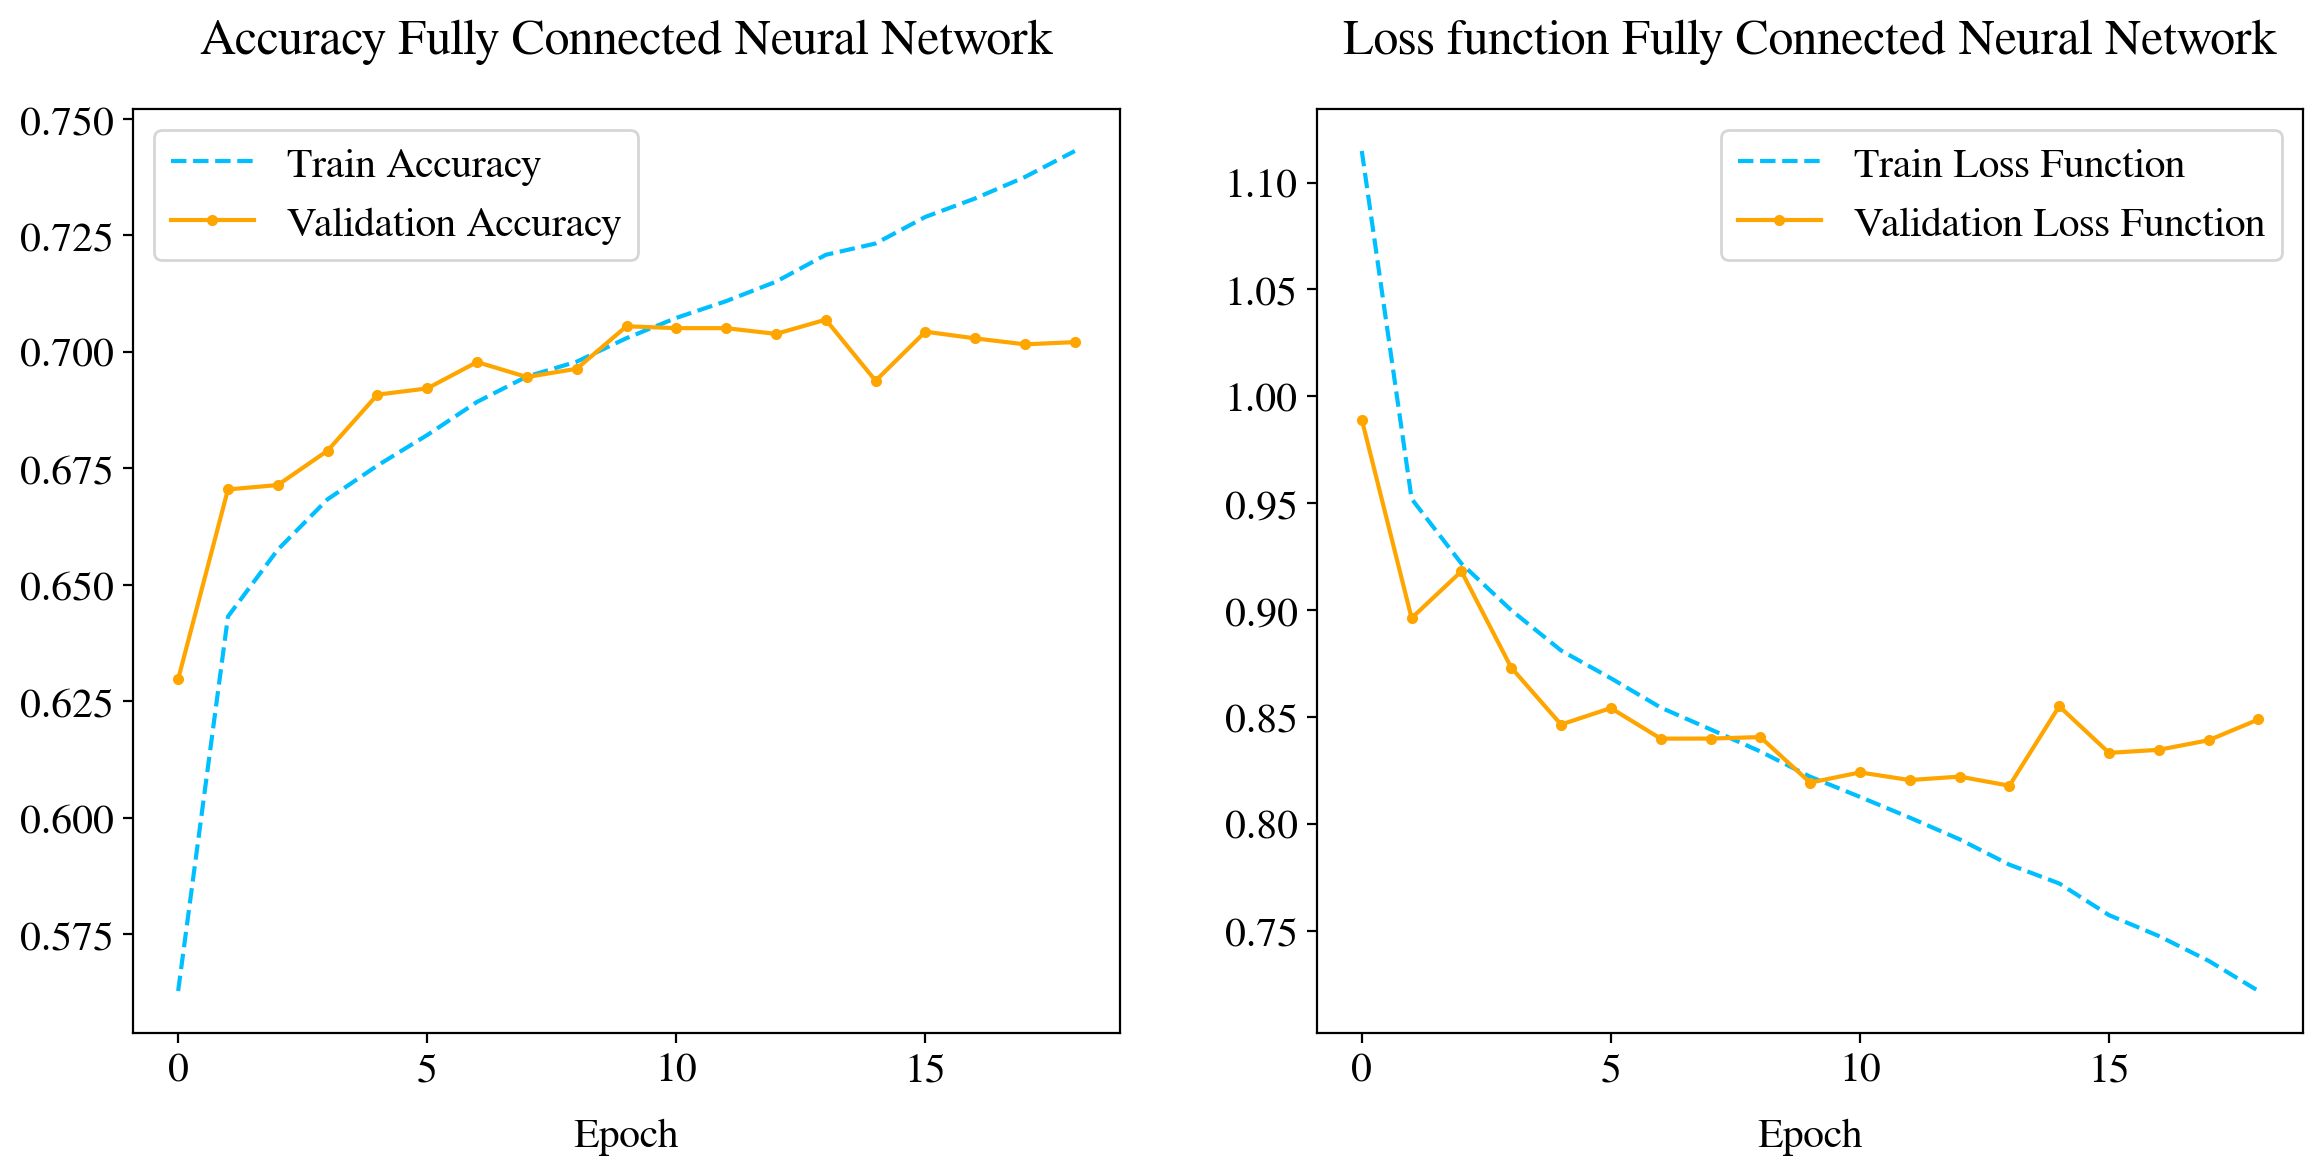

In [ ]:
#class instantiation
m = ModelEval(model0, X_test, Y_test_onehot, model_str="Fully Connected Neural Network")

#methods calling
m.accuracy_loss(pd.DataFrame(history.history))

In [ ]:
model0.evaluate(X_test, Y_test_onehot)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7079 - loss: 0.8355


[0.8426704406738281, 0.7053200006484985]

Confusion matrix of Fully Connected Neural Network


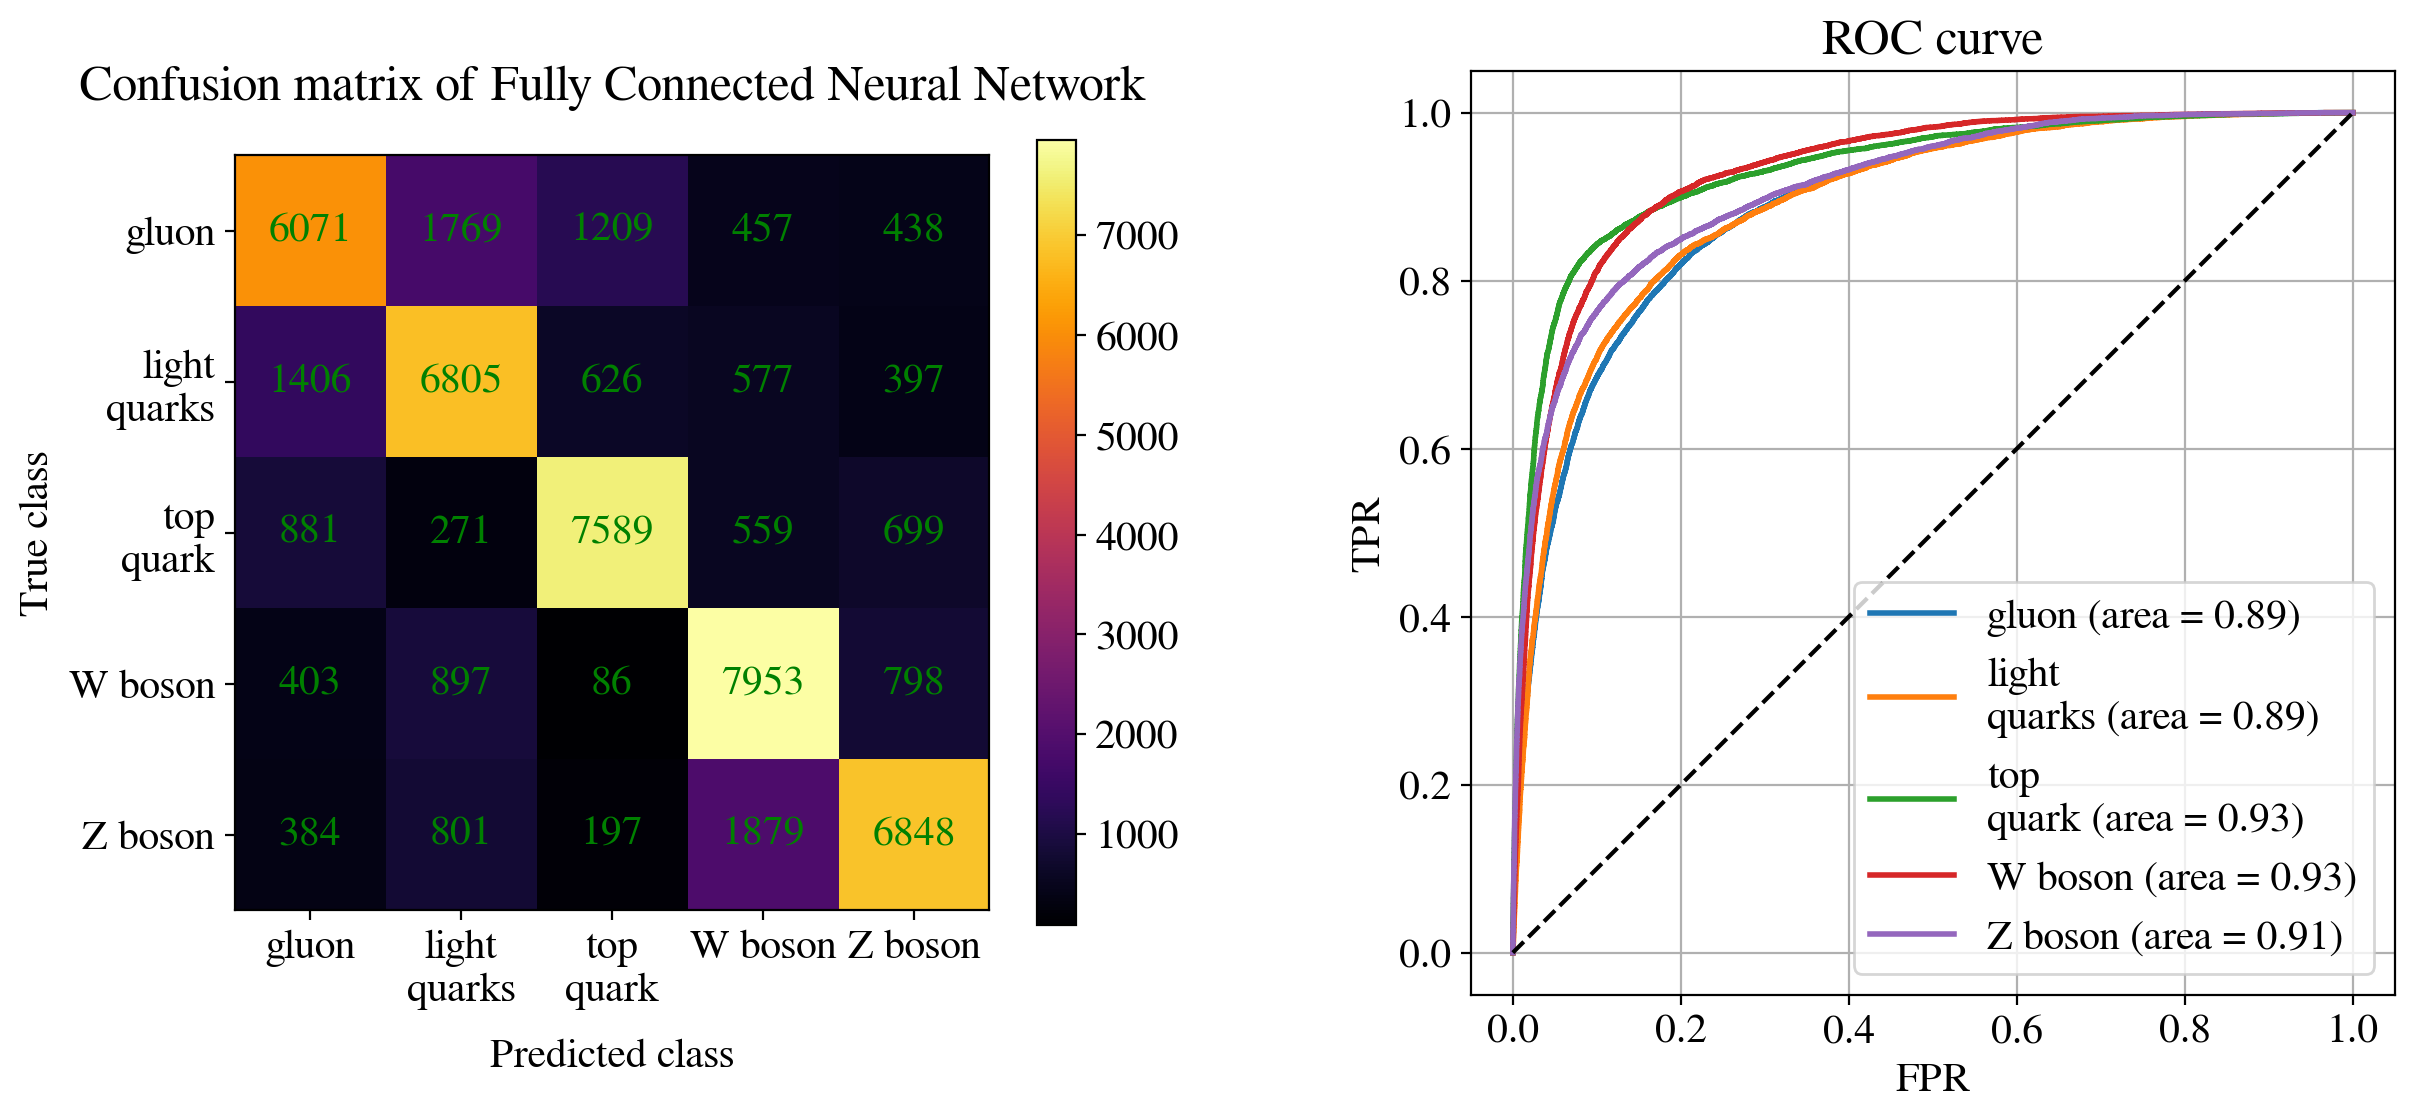

In [ ]:
m.Conf_Matrix_and_ROC_curve()